# **CNN Using Barebones Data**

Barebones means i just took the raw data, converted it into spectrograms, then fed it into CNN. 
I used scaling (stretching and shrinking) to ensure that they all have the same number of features
- Initially I used 128x128

In [32]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import scipy.ndimage

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Model
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [14]:
train_path = 'C:/Users/thato/Documents/Final-Year-Project/Project-V1/train_val_7.csv'
df = pd.read_csv(train_path)

npy_filenames = df['filename_npy'].values
labels = df['primary_label'].values

npy_path = 'C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy/'

In [4]:
sr = 16000

In [41]:
min_duration = df['duration'].min()
min_duration

0.6

In [17]:
# Function to convert audio numpy array to mel spectrogram
def get_mel_spectrogram(npy_file, sr=sr, n_mels=128, hop_length=512):
    audio_data = np.load(npy_path+npy_file) 

    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

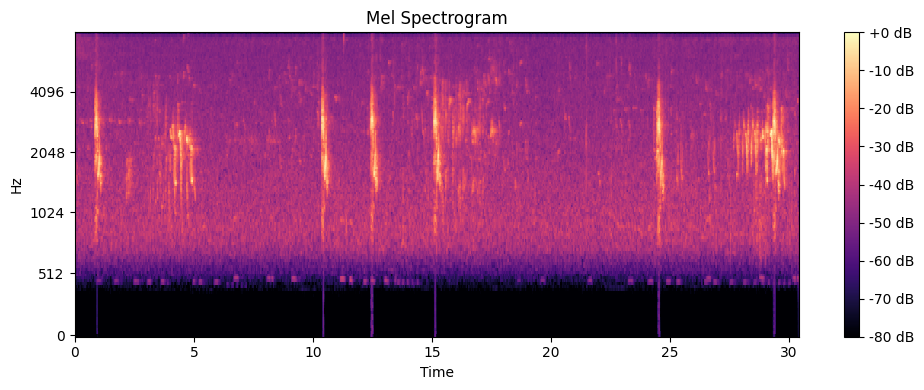

In [11]:
# Plot an example of Mel spectrogram
example_npy = npy_path + npy_filenames[2]
mel_spectrogram_db = get_mel_spectrogram(example_npy)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel') #cmap=viridis
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# Preparing Data for CNN

# Encode labels

In [15]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

## Reshape the Mel spectrograms so they are compatible with the CNN model. 

In [24]:
def get_mel_spectrogram_size(npy_file, sr=sr, n_mels=128, hop_length=512, target_length=None):
    audio_data = np.load(npy_path + npy_file)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # If target length is specified, pad or truncate the spectrogram
    if target_length:
        if mel_spectrogram_db.shape[1] < target_length:
            pad_width = target_length - mel_spectrogram_db.shape[1]
            mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spectrogram_db = mel_spectrogram_db[:, :target_length]
    
    return mel_spectrogram_db

In [33]:
def get_mel_spectrogram_squeeze_stretch(npy_file, sr=sr, n_mels=128, hop_length=512, target_shape=(128, 128)):
    # Load audio data
    audio_data = np.load(npy_path + npy_file)

    # Generate the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Resize the mel spectrogram to 128x128
    mel_spectrogram_resized = scipy.ndimage.zoom(mel_spectrogram_db, (target_shape[0] / mel_spectrogram_db.shape[0], 
                                                                      target_shape[1] / mel_spectrogram_db.shape[1]))

    return mel_spectrogram_resized

In [21]:
# Find the maximum number of frames across all files
max_frames = 0
for npy_file in tqdm(npy_filenames, desc="Processing files"):
    audio_data = np.load(npy_path + npy_file)
    n_frames = (len(audio_data) - 2048) // 512 + 1  # Based on default n_fft=2048, hop_length=512
    if n_frames > max_frames:
        max_frames = n_frames

Processing files: 100%|██████████| 679/679 [00:03<00:00, 220.40it/s]


In [22]:
max_frames

74169

In [34]:
mel_spectrograms = []
for npy_file in tqdm(npy_filenames, desc="Processing files"):
    mel_spec = get_mel_spectrogram_squeeze_stretch(npy_file)
    mel_spec = np.expand_dims(mel_spec, axis=-1)  #+- Add a channel dimension
    mel_spectrograms.append(mel_spec)

Processing files: 100%|██████████| 679/679 [00:22<00:00, 29.78it/s]


In [35]:
mel_spectrograms = np.array(mel_spectrograms)

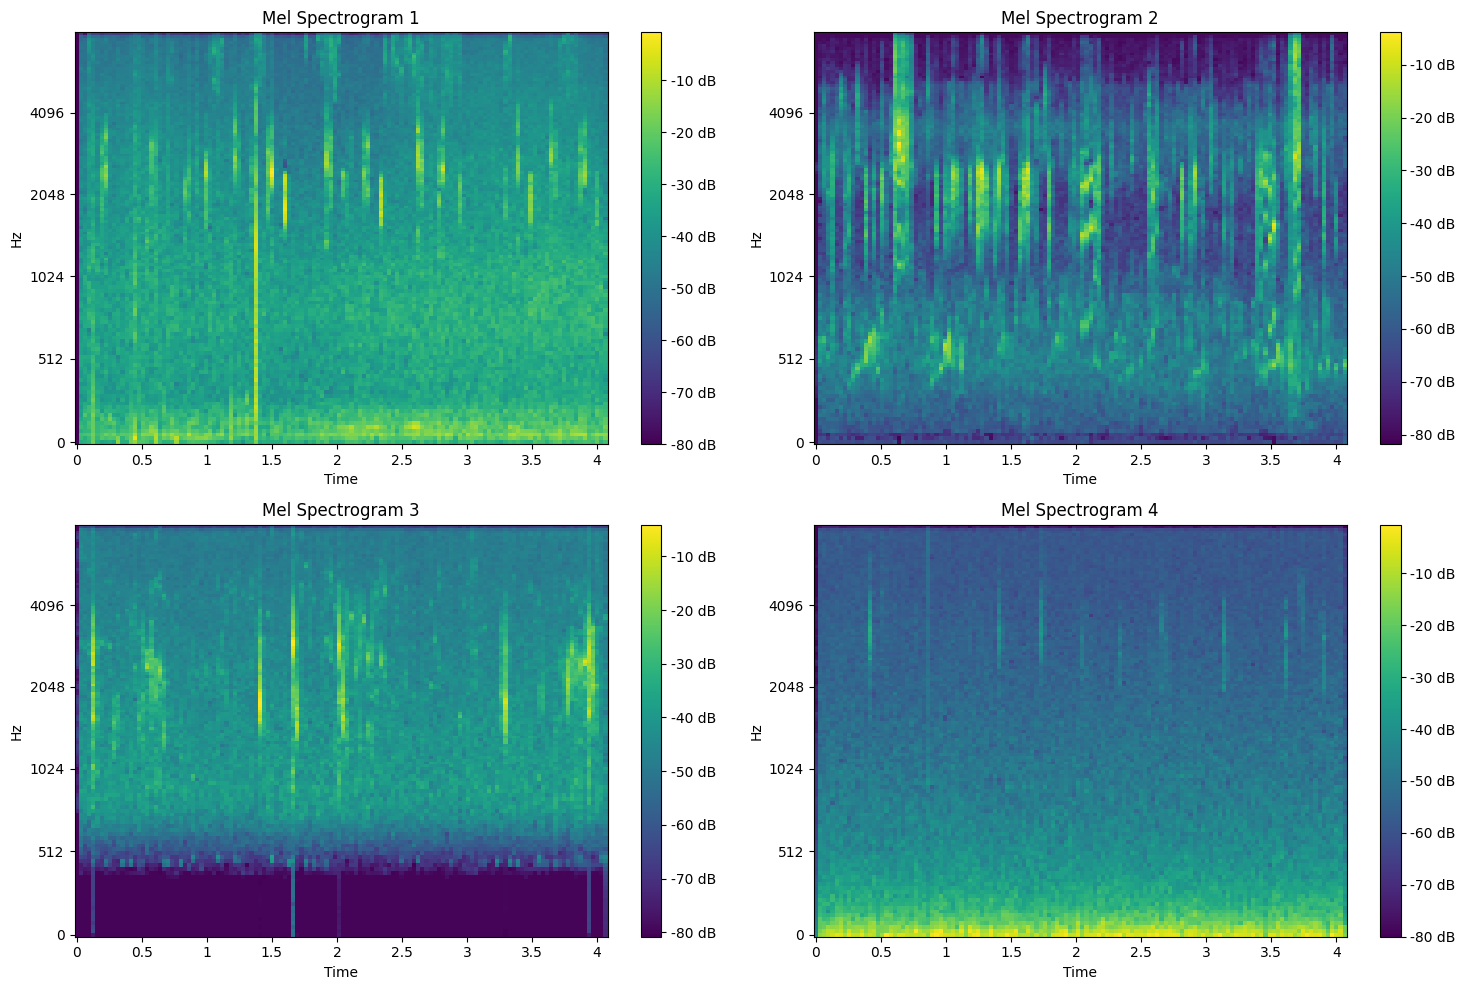

In [36]:
# Number of subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Iterate over the first 4 mel spectrograms and plot each
for i, ax in enumerate(axes.flat):
    mel_spec = mel_spectrograms[i]  # Select the i-th spectrogram
    mel_spec = np.squeeze(mel_spec, axis=-1)  # Remove the extra channel dimension

    img = librosa.display.specshow(mel_spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax, cmap='viridis')
    ax.set_title(f'Mel Spectrogram {i+1}')
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# CNN Model

In [37]:
# Define the CNN model architecture
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(mel_spectrograms.shape[1], mel_spectrograms.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting

# Output layer (adjust units to match number of bird species)
model.add(Dense(len(np.unique(encoded_labels)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Train the Model

In [42]:
X_train, X_val, y_train, y_val = train_test_split(mel_spectrograms, encoded_labels, test_size=0.3, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.2026 - loss: 1.9139 - val_accuracy: 0.1863 - val_loss: 1.9047
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.1803 - loss: 2.1178 - val_accuracy: 0.1863 - val_loss: 1.9032
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.1486 - loss: 1.9370 - val_accuracy: 0.1863 - val_loss: 1.9032
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.1341 - loss: 1.9309 - val_accuracy: 0.1863 - val_loss: 1.9022
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.2152 - loss: 1.9058 - val_accuracy: 0.1863 - val_loss: 1.9023
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.1854 - loss: 1.9080 - val_accuracy: 0.1863 - val_loss: 1.9022
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.1771 - loss: 1.9103 - val_accuracy: 0.1863 - val_loss: 1.9024
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.1643 - loss: 1.9264 - val_accu

In [43]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1946 - loss: 1.8845
Validation Accuracy: 0.18627451360225677


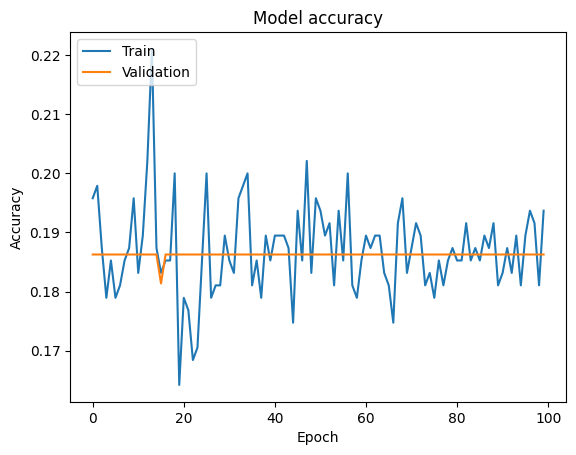

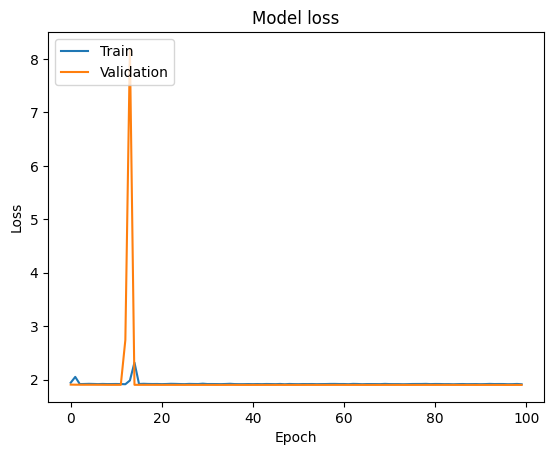

In [44]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()